<a href="https://colab.research.google.com/github/Duckkapon/Portfolio/blob/main/Comparative_Experiments_on_Sentiment_Classification_for_IMDB_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization, BatchNormalization, Dense, Flatten, Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Data Collection

The IMDB Review Dataset from https://ai.stanford.edu/~amaas/data/sentiment/ consists of 50,000 movie reviews evenly divided into positive and negative sentiments. It focuses on highly polarized reviews, with a score threshold for classification. The dataset, released for sentiment analysis benchmarking, shows a model's superior performance, especially when incorporating extra unlabeled data during training.

In [2]:
# downloading the dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5258k      0  0:00:15  0:00:15 --:--:-- 8179k


In total 50,000 reviews, there are 25,000 files for train set and another 25,000 files for test set.

And there are contain 2 class (Positive and Negative) 12,500 files for each class

In [3]:
train_path = "aclImdb/train/"
test_path = "aclImdb/test/"
val_path = "aclImdb/val/"
print(f"train-positive: {len(os.listdir(train_path+'pos'))}")
print(f"train-negative: {len(os.listdir(train_path+'neg'))}")
print(f"test-positive: {len(os.listdir(test_path+'pos'))}")
print(f"test-negative: {len(os.listdir(test_path+'neg'))}")

train-positive: 12500
train-negative: 12500
test-positive: 12500
test-negative: 12500


# Data Exploratory and Preparation

For train set I split apart 20% for validation set

In [4]:
for cat in ["pos/", "neg/"]:
    os.makedirs(val_path+cat)
    files = os.listdir(train_path+cat)
    random.Random(20231227).shuffle(files)
    num_val = int(0.2 * len(files))
    val_files = files[-num_val:]
    for f in val_files:
        os.rename(train_path+cat+f, val_path+cat+f)

print(f"train-positive: {len(os.listdir(train_path+'pos'))}")
print(f"train-negative: {len(os.listdir(train_path+'neg'))}")
print(f"val-positive: {len(os.listdir(val_path+'pos'))}")
print(f"val-negative: {len(os.listdir(val_path+'neg'))}")
print(f"test-positive: {len(os.listdir(test_path+'pos'))}")
print(f"test-negative: {len(os.listdir(test_path+'neg'))}")

train-positive: 10000
train-negative: 10000
val-positive: 2500
val-negative: 2500
test-positive: 12500
test-negative: 12500


 yields batches of texts files from the subdirectories neg and pos, together with labels 0 and 1

In [5]:
# There’s also a train/unsup subdirectory in there, which we don’t need. Let’s delete it:
!rm -r aclImdb/train/unsup

In [2]:
batch_size = 32

train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [7]:
for text, label in train_ds:
  print("text.shape:", text.shape)
  print("text.dtype:", text.dtype)
  print("label.shape:", label.shape)
  print("label.dtype:", label.dtype)
  print("text[0]:", text[0])
  print("label[0]:", label[0])
  break

text.shape: (32,)
text.dtype: <dtype: 'string'>
label.shape: (32,)
label.dtype: <dtype: 'int32'>
text[0]: tf.Tensor(b"Redundant, but again the case. If you enjoy the former SNL comedian and his antics (in this case, Schneider), then you should go. Basic comedy\xc2\x85.man's life is saved by having various animal organs transplanted into him. Unfortunately, he takes on each animal's characteristics. Former Survivor Colleen looks pretty good here, now that she doesn't have open sores on her legs, and a little makeup on her face! D", shape=(), dtype=string)
label[0]: tf.Tensor(0, shape=(), dtype=int32)


## TextVectorization

A preprocessing layer which maps text features to integer sequences.

The processing of each example contains the following steps:

1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
4. Index tokens (associate a unique int value with each token)
5. Transform each example using this index, either into a vector of ints or a dense float vector.

Prepare a dataset that only contains raw text inputs (no labels) for TextVectorization

In [3]:
text_only_train_ds = train_ds.map(lambda x, y: x)
for batch in text_only_train_ds.take(1):
    print(batch)

tf.Tensor(
[b'I get the feeling that the producers of this mess were out to make the most painful, ridiculous Western ever made. "PAINFUL" is the best word I can think of to describe it.<br /><br />On the plus side you have nice color photography and beautiful and well-spoken Rhonda Fleming. My sympathy goes to Jacques Aubuchon (who played the cripple), who acted well enough in an annoying role, written so atrociously that no actor could give an enjoyable performance. The production values were quite good, which only served to highlight the terrible story and screenplay.<br /><br />Things I hated: Stewart Granger looked so little like a western figure, what with his British accent, neat tailored outfit, and silly immaculate always-white kerchief tied around his neck. It got tiresome the way the townspeople and his son were constantly haranguing and insulting Granger, and he never spoke up or replied back. I know we are supposed to suspend disbelief and appreciate Westerns as symbolic m

### Processing words as a set: The Bag-of-Words Approach



In [4]:
max_length = 600
max_tokens = 20000

#### Unigrams with binary encoding

In [10]:
text_vectorization = TextVectorization(
    max_tokens=max_tokens, # Limit the vocabulary to the 20,000 most frequent words.
    output_mode="multi_hot", # Encode the output tokens as multi-hot binary vectors.
)

# Computes a vocabulary of string terms from tokens in a dataset.
text_vectorization.adapt(text_only_train_ds)

# Processing our training, validation, and test dataset.
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

There are one spacials token, index 0 for unknown word

In [11]:
vocabulary = text_vectorization.get_vocabulary()
vocabulary[:30]

['[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'but',
 'movie',
 'film',
 'on',
 'not',
 'his',
 'you',
 'are',
 'have',
 'be',
 'he',
 'one',
 'its']

#### Bigrams with binary encoding

In [12]:
text_vectorization = TextVectorization(
    max_tokens=max_tokens, # Limit the vocabulary to the 20,000 most frequent words.
    output_mode="multi_hot", # Encode the output tokens as multi-hot binary vectors.
    ngrams = 2
)

# Computes a vocabulary of string terms from tokens in a dataset.
text_vectorization.adapt(text_only_train_ds)

# Processing our training, validation, and test dataset.
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### Unigrams with TF-IDF encoding

In [13]:
text_vectorization = TextVectorization(
    max_tokens=max_tokens, # Limit the vocabulary to the 20,000 most frequent words.
    output_mode="tf_idf", # Encode the output tokens as TF-IDF vectors.
)

# Computes a vocabulary of string terms from tokens in a dataset.
text_vectorization.adapt(text_only_train_ds)

# Processing our training, validation, and test dataset.
tfidf_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### Bigrams with TF-IDF encoding

In [14]:
text_vectorization = TextVectorization(
    max_tokens=max_tokens, # Limit the vocabulary to the 20,000 most frequent words.
    output_mode="tf_idf", # Encode the output tokens as TF-IDF vectors.
    ngrams = 2
)

# Computes a vocabulary of string terms from tokens in a dataset.
text_vectorization.adapt(text_only_train_ds)

# Processing our training, validation, and test dataset.
tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### Processing words as a sequence: The Sequence Model Approach



#### Unigrams with integer indices

In [5]:
text_vectorization = TextVectorization(
    max_tokens=max_tokens, # Limit the vocabulary to the 20,000 most frequent words.
    output_mode="int", # Encode the output tokens as integer index vectors.
    output_sequence_length = max_length # the output will have its time dimension padded or truncated.
)

# Computes a vocabulary of string terms from tokens in a dataset.
text_vectorization.adapt(text_only_train_ds)

# Processing our training, validation, and test dataset.
int_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

There are one spacials token, index 0 for padding and index 1 for unknown word

In [16]:
vocabulary = text_vectorization.get_vocabulary()
vocabulary[:30]

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'but',
 'movie',
 'film',
 'on',
 'not',
 'his',
 'you',
 'are',
 'have',
 'be',
 'he',
 'one']

#### Bigrams with integer indices

In [6]:
text_vectorization = TextVectorization(
    max_tokens=max_tokens, # Limit the vocabulary to the 20,000 most frequent words.
    output_mode="int", # Encode the output tokens as integer index vectors.
    ngrams = 2,
    output_sequence_length = max_length # the output will have its time dimension padded or truncated.
)

# Computes a vocabulary of string terms from tokens in a dataset.
text_vectorization.adapt(text_only_train_ds)

# Processing our training, validation, and test dataset.
int_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

# Build classification model

In [9]:
def plot_loss(train_set, val_set, test_set):
    # evaluation
    print("evaluate train set")
    print(model.evaluate(train_set))
    print("evaluate val set")
    print(model.evaluate(val_set))
    print("evaluate test set")
    print(model.evaluate(test_set))

    # loss
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history.history["loss"], label="loss")
    ax[0].plot(history.history["val_loss"], label="val_loss")
    ax[0].legend()
    ax[1].plot(history.history["accuracy"], label="accuracy")
    ax[1].plot(history.history["val_accuracy"], label="val_accuracy")
    ax[1].legend()
    plt.show()

## Bag of Words Approach

### Dense

In [19]:
def get_dense():
    model = Sequential()
    model.add(Input(shape=(max_tokens,)))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [8]:
def model_fit(model, train_set, val_set):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5)
    history = model.fit(train_set,
                        validation_data=val_set,
                        epochs=20,
                        callbacks=[early_stopping])
    return history

In [21]:
get_dense().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                640032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 640065 (2.44 MB)
Trainable params: 640065 (2.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with binary encoding

In [22]:
model = get_dense()
history = model_fit(model, binary_1gram_train_ds, binary_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 9s 10ms/step - loss: 0.3681 - accuracy: 0.8450 - val_loss: 0.2832 - val_accuracy: 0.8834
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 0.1919 - accuracy: 0.9305 - val_loss: 0.2914 - val_accuracy: 0.8832
Epoch 3/20
625/625 [==============================] - 6s 9ms/step - loss: 0.1270 - accuracy: 0.9576 - val_loss: 0.3193 - val_accuracy: 0.8826
Epoch 4/20
625/625 [==============================] - 5s 7ms/step - loss: 0.0915 - accuracy: 0.9685 - val_loss: 0.3519 - val_accuracy: 0.8818
Epoch 5/20
625/625 [==============================] - 5s 9ms/step - loss: 0.0692 - accuracy: 0.9774 - val_loss: 0.3934 - val_accuracy: 0.8810
Epoch 6/20
625/625 [==============================] - 4s 6ms/step - loss: 0.0532 - accuracy: 0.9829 - val_loss: 0.4186 - val_accuracy: 0.8796


evaluate train set
625/625 [==============================] - 3s 4ms/step - loss: 0.1712 - accuracy: 0.9480
[0.17117324471473694, 0.9480000138282776]
evaluate val set
157/157 [==============================] - 1s 4ms/step - loss: 0.2832 - accuracy: 0.8834
[0.2831808626651764, 0.883400022983551]
evaluate test set
782/782 [==============================] - 5s 7ms/step - loss: 0.2816 - accuracy: 0.8870
[0.28158891201019287, 0.8870000243186951]


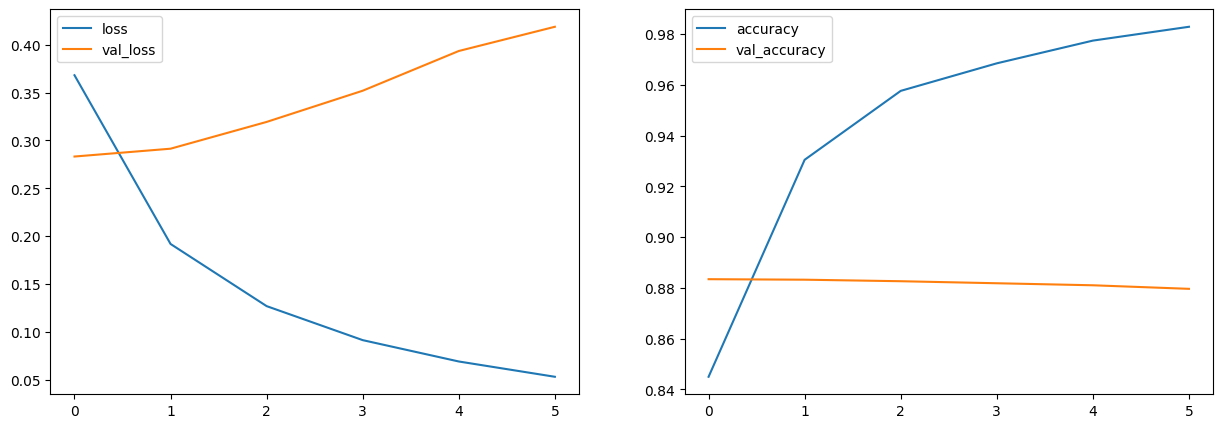

In [23]:
plot_loss(binary_1gram_train_ds, binary_1gram_val_ds, binary_1gram_test_ds)

#### Bigrams with binary encoding

In [24]:
model = get_dense()
history = model_fit(model, binary_2gram_train_ds, binary_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 7s 10ms/step - loss: 0.3418 - accuracy: 0.8591 - val_loss: 0.2711 - val_accuracy: 0.8884
Epoch 2/20
625/625 [==============================] - 5s 8ms/step - loss: 0.1603 - accuracy: 0.9424 - val_loss: 0.2827 - val_accuracy: 0.8876
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.0996 - accuracy: 0.9668 - val_loss: 0.3160 - val_accuracy: 0.8872
Epoch 4/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0625 - accuracy: 0.9789 - val_loss: 0.3577 - val_accuracy: 0.8840
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 0.0450 - accuracy: 0.9850 - val_loss: 0.4017 - val_accuracy: 0.8786
Epoch 6/20
625/625 [==============================] - 9s 15ms/step - loss: 0.0365 - accuracy: 0.9885 - val_loss: 0.4312 - val_accuracy: 0.8840


evaluate train set
625/625 [==============================] - 4s 5ms/step - loss: 0.1410 - accuracy: 0.9618
[0.14102515578269958, 0.9617999792098999]
evaluate val set
157/157 [==============================] - 1s 5ms/step - loss: 0.2711 - accuracy: 0.8884
[0.2710835337638855, 0.8884000182151794]
evaluate test set
782/782 [==============================] - 6s 7ms/step - loss: 0.2566 - accuracy: 0.8973
[0.25659048557281494, 0.8972799777984619]


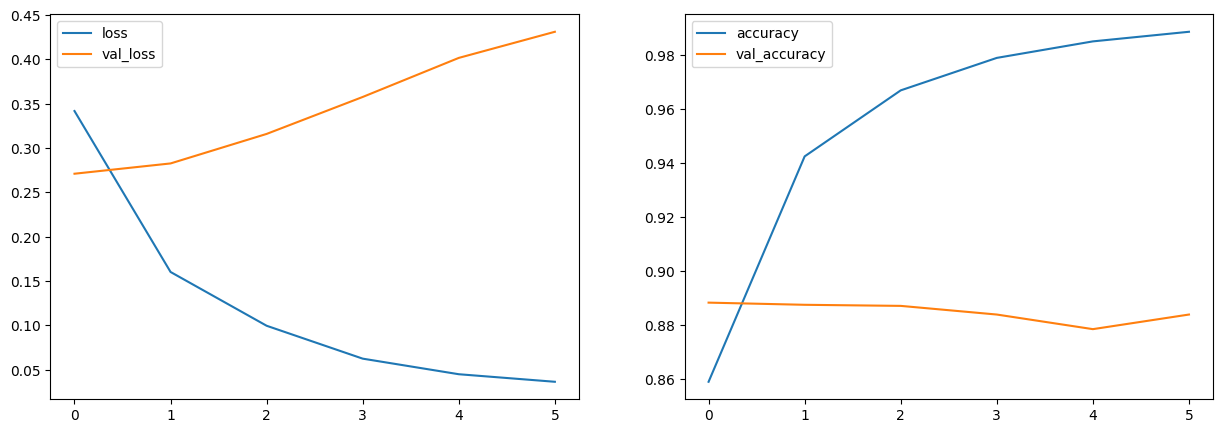

In [25]:
plot_loss(binary_2gram_train_ds, binary_2gram_val_ds, binary_2gram_test_ds)

#### Unigrams with TF-IDF encoding

In [26]:
model = get_dense()
history = model_fit(model, tfidf_1gram_train_ds, tfidf_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 7s 9ms/step - loss: 0.3792 - accuracy: 0.8414 - val_loss: 0.2958 - val_accuracy: 0.8834
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 0.1883 - accuracy: 0.9306 - val_loss: 0.3014 - val_accuracy: 0.8840
Epoch 3/20
625/625 [==============================] - 6s 9ms/step - loss: 0.1139 - accuracy: 0.9608 - val_loss: 0.3299 - val_accuracy: 0.8828
Epoch 4/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0813 - accuracy: 0.9728 - val_loss: 0.3667 - val_accuracy: 0.8832
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 0.0606 - accuracy: 0.9790 - val_loss: 0.4079 - val_accuracy: 0.8822
Epoch 6/20
625/625 [==============================] - 6s 10ms/step - loss: 0.0453 - accuracy: 0.9840 - val_loss: 0.4494 - val_accuracy: 0.8786
Epoch 7/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0447 - accuracy: 0.9855 - val_loss: 0.4897 - val_accuracy: 0.8738


evaluate train set
625/625 [==============================] - 4s 6ms/step - loss: 0.0801 - accuracy: 0.9810
[0.0801248550415039, 0.9810000061988831]
evaluate val set
157/157 [==============================] - 1s 4ms/step - loss: 0.3014 - accuracy: 0.8840
[0.30143973231315613, 0.8840000033378601]
evaluate test set
782/782 [==============================] - 4s 5ms/step - loss: 0.3251 - accuracy: 0.8708
[0.3251495659351349, 0.8707600235939026]


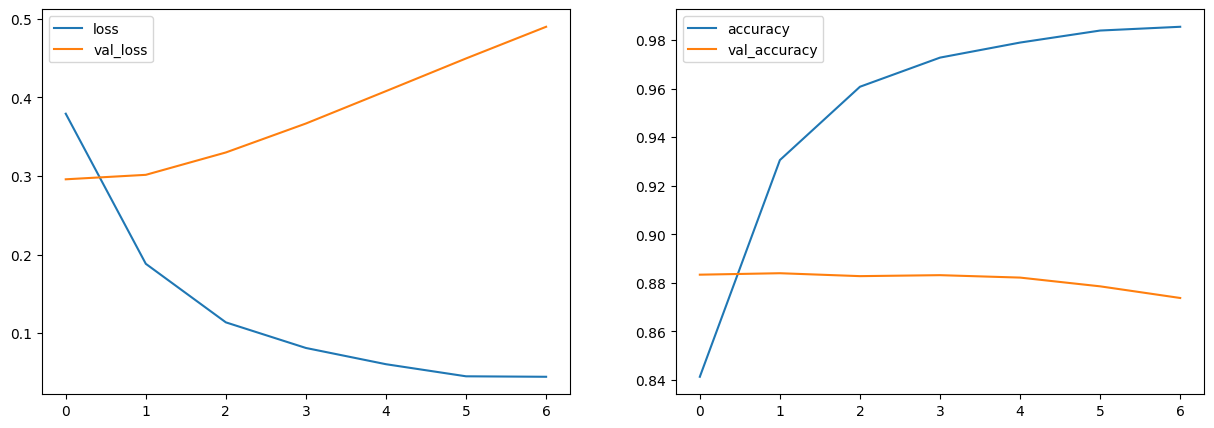

In [27]:
plot_loss(tfidf_1gram_train_ds, tfidf_1gram_val_ds, tfidf_1gram_test_ds)

#### Bigrams with TF-IDF encoding

In [28]:
model = get_dense()
history = model_fit(model, tfidf_2gram_train_ds, tfidf_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 6s 8ms/step - loss: 0.4678 - accuracy: 0.8096 - val_loss: 0.2882 - val_accuracy: 0.8860
Epoch 2/20
625/625 [==============================] - 6s 9ms/step - loss: 0.2476 - accuracy: 0.8977 - val_loss: 0.2975 - val_accuracy: 0.8862
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.1943 - accuracy: 0.9189 - val_loss: 0.2927 - val_accuracy: 0.8844
Epoch 4/20
625/625 [==============================] - 6s 9ms/step - loss: 0.1537 - accuracy: 0.9334 - val_loss: 0.3234 - val_accuracy: 0.8842
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.1315 - accuracy: 0.9428 - val_loss: 0.3313 - val_accuracy: 0.8850
Epoch 6/20
625/625 [==============================] - 6s 9ms/step - loss: 0.1252 - accuracy: 0.9453 - val_loss: 0.3268 - val_accuracy: 0.8826
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 0.1035 - accuracy: 0.9551 - val_loss: 0.4085 - val_accuracy: 0.8874
Epo

evaluate train set
625/625 [==============================] - 5s 8ms/step - loss: 0.0307 - accuracy: 0.9886
[0.030651263892650604, 0.9885500073432922]
evaluate val set
157/157 [==============================] - 1s 6ms/step - loss: 0.4085 - accuracy: 0.8874
[0.40845614671707153, 0.8873999714851379]
evaluate test set
782/782 [==============================] - 6s 7ms/step - loss: 0.3840 - accuracy: 0.8902
[0.3839731514453888, 0.8902000188827515]


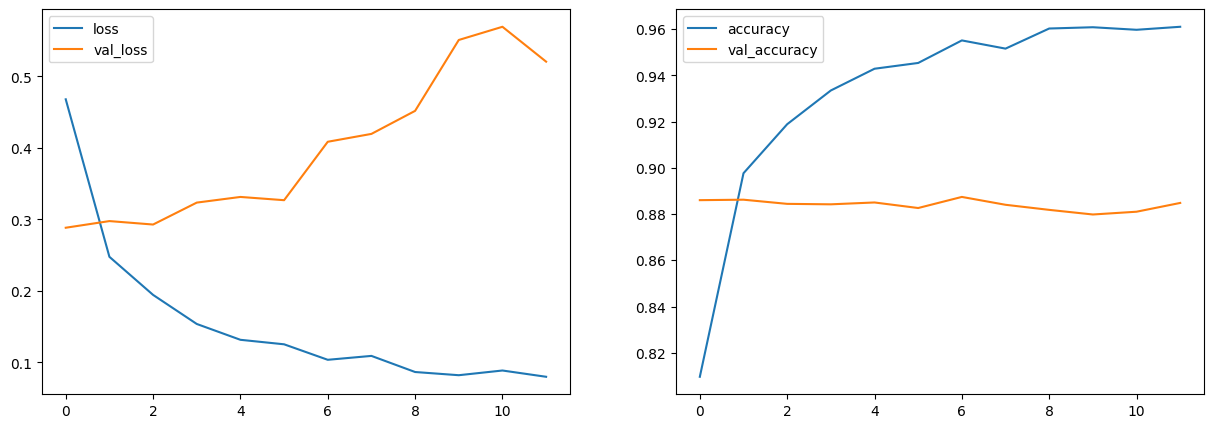

In [29]:
plot_loss(tfidf_2gram_train_ds, tfidf_2gram_val_ds, tfidf_2gram_test_ds)

## Sequence Model Approach

### Embedding (without mask_zero) + Dense

In [30]:
def get_dense():
    model = Sequential()
    # model.add(Input(shape=()))
    model.add(Embedding(input_dim=max_tokens, output_dim=128, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [31]:
get_dense().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 128)          2560000   
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense_10 (Dense)            (None, 32)                2457632   
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5017665 (19.14 MB)
Trainable params: 5017665 (19.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [32]:
model = get_dense()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 50s 77ms/step - loss: 0.5762 - accuracy: 0.6568 - val_loss: 0.3618 - val_accuracy: 0.8396
Epoch 2/20
625/625 [==============================] - 24s 39ms/step - loss: 0.1914 - accuracy: 0.9261 - val_loss: 0.3880 - val_accuracy: 0.8568
Epoch 3/20
625/625 [==============================] - 16s 25ms/step - loss: 0.0320 - accuracy: 0.9903 - val_loss: 0.5120 - val_accuracy: 0.8626
Epoch 4/20
625/625 [==============================] - 10s 16ms/step - loss: 0.0056 - accuracy: 0.9995 - val_loss: 0.5989 - val_accuracy: 0.8546
Epoch 5/20
625/625 [==============================] - 9s 14ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.6966 - val_accuracy: 0.8580
Epoch 6/20
625/625 [==============================] - 8s 12ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.7210 - val_accuracy: 0.8576
Epoch 7/20
625/625 [==============================] - 7s 12ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.8649 - val_accuracy: 0.

evaluate train set
625/625 [==============================] - 3s 4ms/step - loss: 0.0021 - accuracy: 0.9999
[0.002087110187858343, 0.9999499917030334]
evaluate val set
157/157 [==============================] - 1s 4ms/step - loss: 0.5120 - accuracy: 0.8626
[0.5120198726654053, 0.8626000285148621]
evaluate test set
782/782 [==============================] - 3s 4ms/step - loss: 0.5250 - accuracy: 0.8510
[0.5249563455581665, 0.8510400056838989]


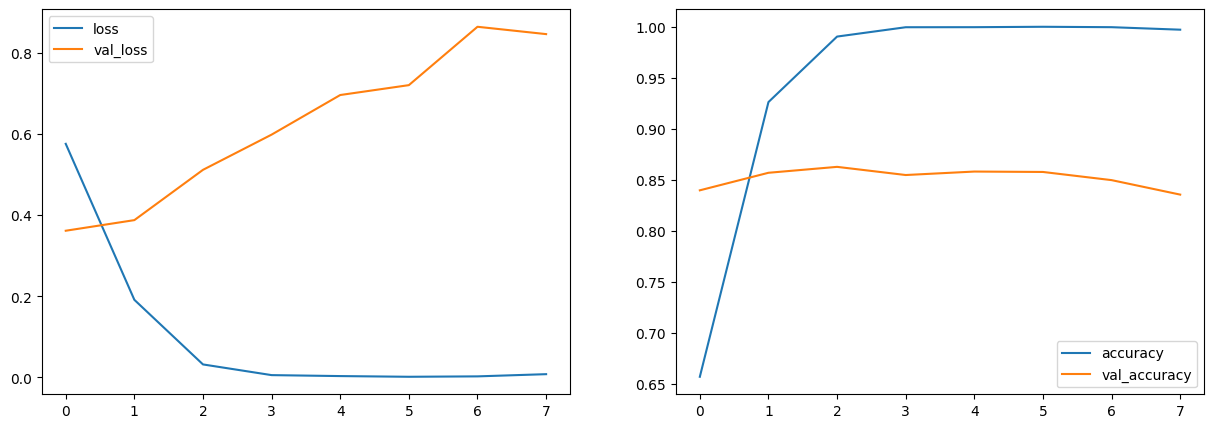

In [33]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [34]:
model = get_dense()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 50s 78ms/step - loss: 0.5127 - accuracy: 0.7100 - val_loss: 0.3617 - val_accuracy: 0.8454
Epoch 2/20
625/625 [==============================] - 24s 38ms/step - loss: 0.1360 - accuracy: 0.9485 - val_loss: 0.4599 - val_accuracy: 0.8596
Epoch 3/20
625/625 [==============================] - 14s 23ms/step - loss: 0.0146 - accuracy: 0.9961 - val_loss: 0.5494 - val_accuracy: 0.8648
Epoch 4/20
625/625 [==============================] - 11s 18ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.6027 - val_accuracy: 0.8666
Epoch 5/20
625/625 [==============================] - 10s 16ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.7226 - val_accuracy: 0.8538
Epoch 6/20
625/625 [==============================] - 8s 14ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.8083 - val_accuracy: 0.8558
Epoch 7/20
625/625 [==============================] - 8s 13ms/step - loss: 7.2280e-04 - accuracy: 0.9999 - val_loss: 0.8385 - val_accurac

evaluate train set
625/625 [==============================] - 3s 5ms/step - loss: 2.8366e-04 - accuracy: 1.0000
[0.00028365838807076216, 1.0]
evaluate val set
157/157 [==============================] - 1s 5ms/step - loss: 0.6027 - accuracy: 0.8666
[0.6027055382728577, 0.866599977016449]
evaluate test set
782/782 [==============================] - 5s 6ms/step - loss: 0.5584 - accuracy: 0.8643
[0.5584366917610168, 0.8642799854278564]


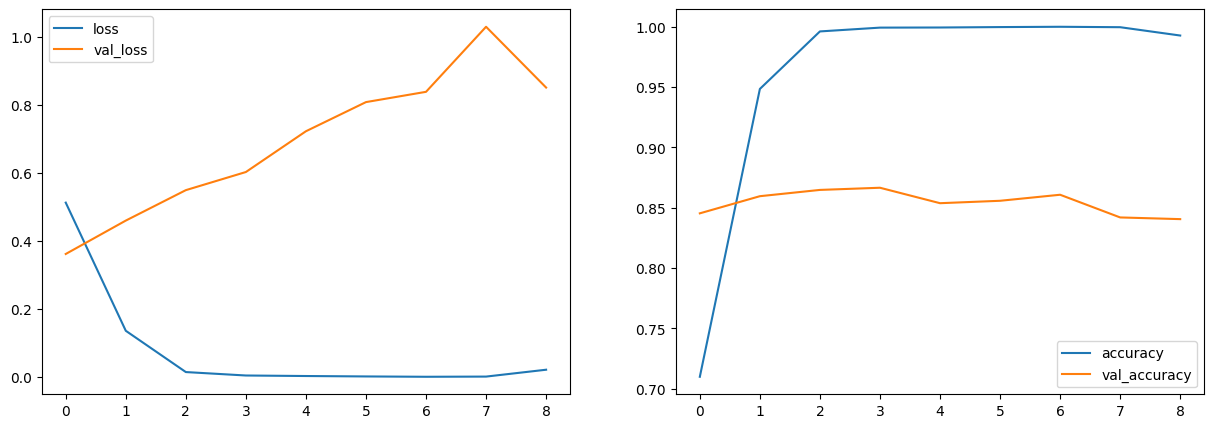

In [35]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (with mask_zero) + Dense

In [36]:
def get_dense():
    model = Sequential()
    # model.add(Input(shape=()))
    model.add(Embedding(input_dim=max_tokens, output_dim=128, input_length=max_length, mask_zero=True))
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [37]:
get_dense().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 600, 128)          2560000   
                                                                 
 flatten_3 (Flatten)         (None, 76800)             0         
                                                                 
 dense_16 (Dense)            (None, 32)                2457632   
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5017665 (19.14 MB)
Trainable params: 5017665 (19.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [38]:
model = get_dense()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 51s 81ms/step - loss: 0.5675 - accuracy: 0.6594 - val_loss: 0.3417 - val_accuracy: 0.8526
Epoch 2/20
625/625 [==============================] - 24s 39ms/step - loss: 0.1942 - accuracy: 0.9222 - val_loss: 0.4403 - val_accuracy: 0.8516
Epoch 3/20
625/625 [==============================] - 14s 22ms/step - loss: 0.0324 - accuracy: 0.9902 - val_loss: 0.5315 - val_accuracy: 0.8552
Epoch 4/20
625/625 [==============================] - 12s 19ms/step - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.6333 - val_accuracy: 0.8594
Epoch 5/20
625/625 [==============================] - 8s 12ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.7442 - val_accuracy: 0.8544
Epoch 6/20
625/625 [==============================] - 8s 13ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.7889 - val_accuracy: 0.8598
Epoch 7/20
625/625 [==============================] - 8s 12ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.9181 - val_accuracy: 0.

evaluate train set
625/625 [==============================] - 2s 4ms/step - loss: 7.6767e-05 - accuracy: 1.0000
[7.676699897274375e-05, 1.0]
evaluate val set
157/157 [==============================] - 1s 4ms/step - loss: 0.7889 - accuracy: 0.8598
[0.7889068126678467, 0.8597999811172485]
evaluate test set
782/782 [==============================] - 5s 6ms/step - loss: 0.7985 - accuracy: 0.8505
[0.7985478639602661, 0.8504800200462341]


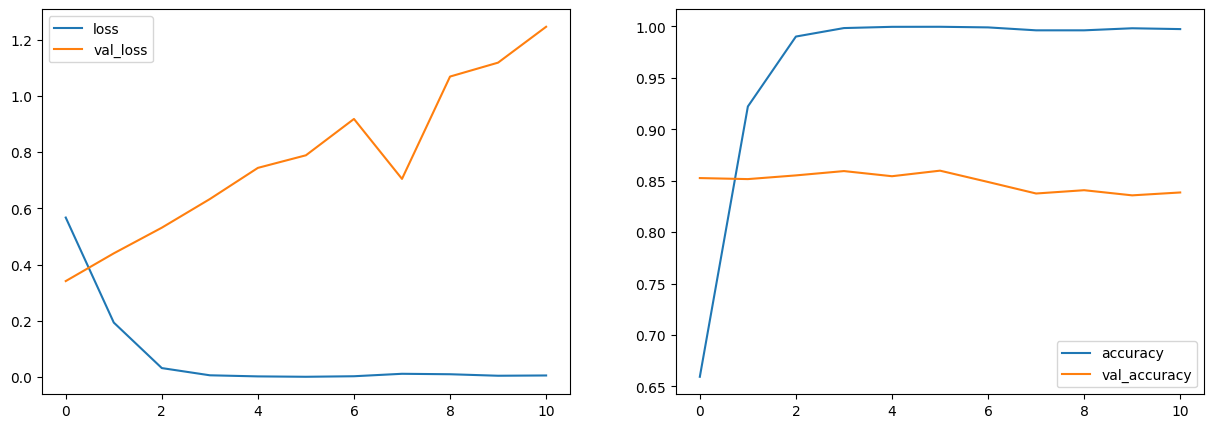

In [39]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [40]:
model = get_dense()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 54s 85ms/step - loss: 0.5939 - accuracy: 0.6211 - val_loss: 0.3574 - val_accuracy: 0.8442
Epoch 2/20
625/625 [==============================] - 23s 38ms/step - loss: 0.2095 - accuracy: 0.9178 - val_loss: 0.3870 - val_accuracy: 0.8756
Epoch 3/20
625/625 [==============================] - 14s 23ms/step - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.5091 - val_accuracy: 0.8644
Epoch 4/20
625/625 [==============================] - 9s 15ms/step - loss: 0.0066 - accuracy: 0.9982 - val_loss: 0.6103 - val_accuracy: 0.8672
Epoch 5/20
625/625 [==============================] - 10s 17ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.6992 - val_accuracy: 0.8666
Epoch 6/20
625/625 [==============================] - 7s 12ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.7729 - val_accuracy: 0.8536
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.9104 - val_accuracy: 0.

evaluate train set
625/625 [==============================] - 5s 7ms/step - loss: 0.0125 - accuracy: 0.9972
[0.012466182932257652, 0.9971500039100647]
evaluate val set
157/157 [==============================] - 1s 5ms/step - loss: 0.3870 - accuracy: 0.8756
[0.3869507312774658, 0.8755999803543091]
evaluate test set
782/782 [==============================] - 4s 5ms/step - loss: 0.3764 - accuracy: 0.8706
[0.3764446973800659, 0.870639979839325]


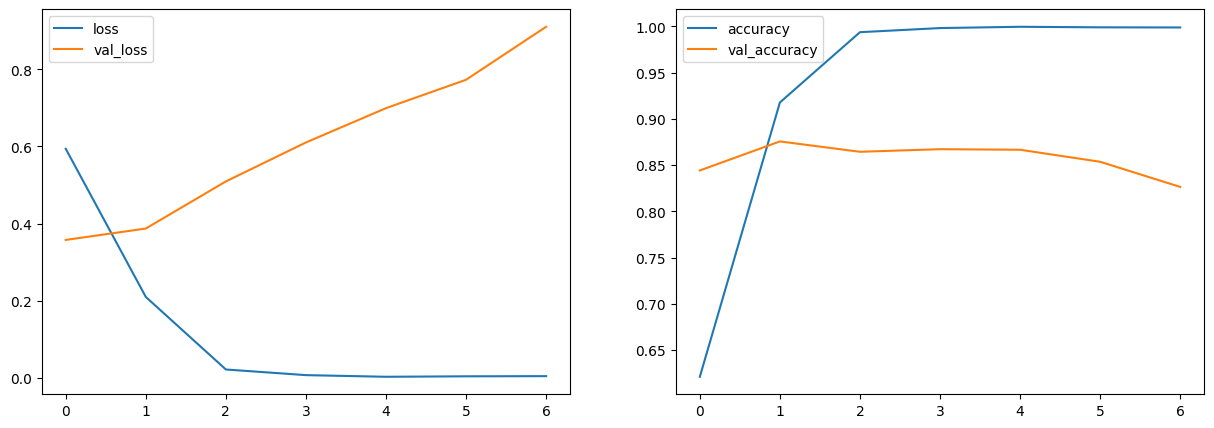

In [41]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (without mask_zero) + RNN

In [16]:
def get_rnn():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128))
    model.add(SimpleRNN(32, activation="tanh"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [17]:
get_rnn().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2560000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2565185 (9.79 MB)
Trainable params: 2565185 (9.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [18]:
model = get_rnn()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
 58/625 [=>............................] - ETA: 6:22 - loss: 0.7054 - accuracy: 0.5113

KeyboardInterrupt: ignored

In [ ]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [ ]:
model = get_rnn()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

In [ ]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (with mask_zero) + RNN

In [ ]:
def get_rnn():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True))
    model.add(SimpleRNN(32, activation="tanh"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
get_rnn().summary()

#### Unigrams with integer

In [ ]:
model = get_rnn()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

In [ ]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [ ]:
model = get_rnn()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

In [ ]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (without mask_zero) + GRU

In [57]:
def get_gru():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128))
    model.add(GRU(32, activation="tanh"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [58]:
get_gru().summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 128)         2560000   
                                                                 
 gru_2 (GRU)                 (None, 32)                15552     
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2575585 (9.83 MB)
Trainable params: 2575585 (9.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [59]:
model = get_gru()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 65s 100ms/step - loss: 0.6939 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 2/20
625/625 [==============================] - 37s 60ms/step - loss: 0.6920 - accuracy: 0.5016 - val_loss: 0.6951 - val_accuracy: 0.5042
Epoch 3/20
625/625 [==============================] - 28s 45ms/step - loss: 0.6841 - accuracy: 0.5116 - val_loss: 0.7094 - val_accuracy: 0.5028
Epoch 4/20
625/625 [==============================] - 24s 39ms/step - loss: 0.6690 - accuracy: 0.5281 - val_loss: 0.7274 - val_accuracy: 0.5006
Epoch 5/20
625/625 [==============================] - 21s 33ms/step - loss: 0.6620 - accuracy: 0.5296 - val_loss: 0.7346 - val_accuracy: 0.5034
Epoch 6/20
625/625 [==============================] - 20s 32ms/step - loss: 0.6599 - accuracy: 0.5244 - val_loss: 0.7397 - val_accuracy: 0.5032
Epoch 7/20
625/625 [==============================] - 22s 35ms/step - loss: 0.6590 - accuracy: 0.5322 - val_loss: 0.7387 - val_accuracy

evaluate train set
625/625 [==============================] - 7s 12ms/step - loss: 0.6869 - accuracy: 0.5171
[0.6868506669998169, 0.5171499848365784]
evaluate val set
157/157 [==============================] - 2s 11ms/step - loss: 0.6951 - accuracy: 0.5042
[0.695084810256958, 0.5041999816894531]
evaluate test set
782/782 [==============================] - 10s 13ms/step - loss: 0.6944 - accuracy: 0.5036
[0.69440096616745, 0.503600001335144]


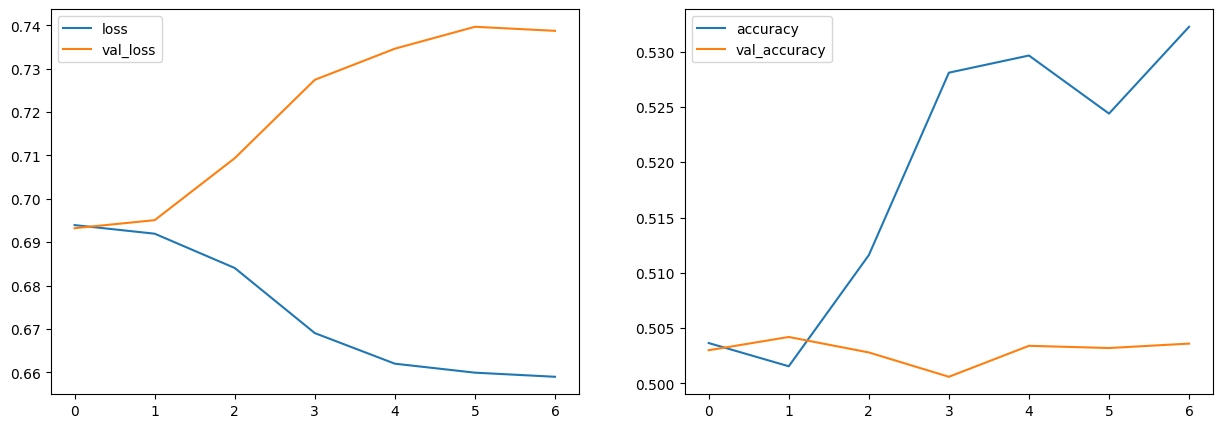

In [60]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [61]:
model = get_gru()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 66s 102ms/step - loss: 0.6936 - accuracy: 0.5048 - val_loss: 0.6929 - val_accuracy: 0.5132
Epoch 2/20
625/625 [==============================] - 37s 60ms/step - loss: 0.6800 - accuracy: 0.5430 - val_loss: 0.7095 - val_accuracy: 0.5134
Epoch 3/20
625/625 [==============================] - 28s 45ms/step - loss: 0.6012 - accuracy: 0.5972 - val_loss: 0.8079 - val_accuracy: 0.5150
Epoch 4/20
625/625 [==============================] - 22s 36ms/step - loss: 0.5484 - accuracy: 0.6119 - val_loss: 0.8928 - val_accuracy: 0.5132
Epoch 5/20
625/625 [==============================] - 24s 38ms/step - loss: 0.5432 - accuracy: 0.6218 - val_loss: 0.9515 - val_accuracy: 0.4970
Epoch 6/20
625/625 [==============================] - 22s 35ms/step - loss: 0.5326 - accuracy: 0.6204 - val_loss: 0.9549 - val_accuracy: 0.5136
Epoch 7/20
625/625 [==============================] - 20s 32ms/step - loss: 0.5431 - accuracy: 0.6159 - val_loss: 0.9309 - val_accuracy

evaluate train set
625/625 [==============================] - 9s 14ms/step - loss: 0.5511 - accuracy: 0.6163
[0.5511265993118286, 0.6162999868392944]
evaluate val set
157/157 [==============================] - 2s 12ms/step - loss: 0.8079 - accuracy: 0.5150
[0.8079314231872559, 0.5149999856948853]
evaluate test set
782/782 [==============================] - 12s 16ms/step - loss: 0.7934 - accuracy: 0.5059
[0.7934339046478271, 0.5058799982070923]


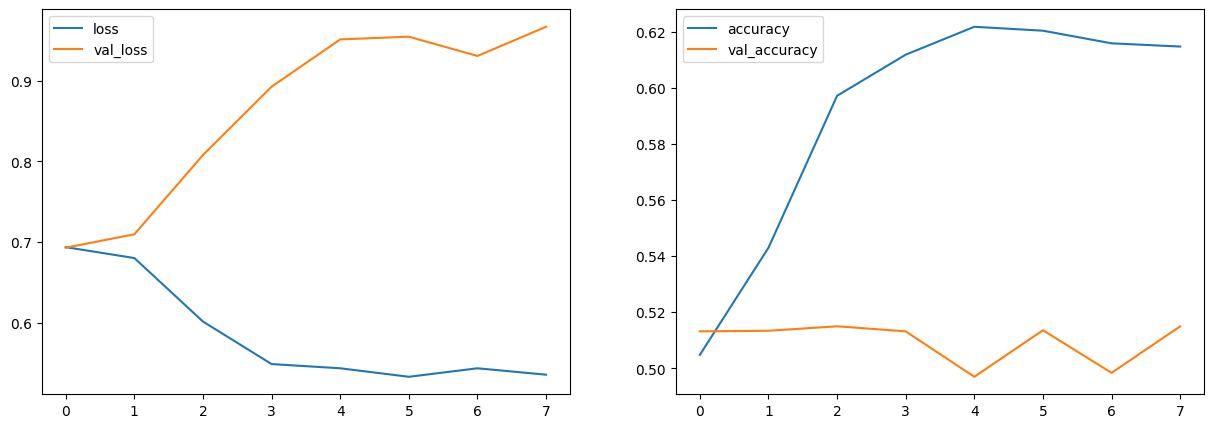

In [62]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (with mask_zero) + GRU

In [3]:
def get_gru():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True))
    model.add(GRU(32, activation="tanh"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [13]:
get_gru().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 gru (GRU)                   (None, 32)                15552     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2575585 (9.83 MB)
Trainable params: 2575585 (9.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [17]:
model = get_gru()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 76s 110ms/step - loss: 0.4395 - accuracy: 0.7961 - val_loss: 0.3346 - val_accuracy: 0.8630
Epoch 2/20
625/625 [==============================] - 42s 66ms/step - loss: 0.2228 - accuracy: 0.9171 - val_loss: 0.3807 - val_accuracy: 0.8602
Epoch 3/20
625/625 [==============================] - 30s 47ms/step - loss: 0.1679 - accuracy: 0.9421 - val_loss: 0.3713 - val_accuracy: 0.8782
Epoch 4/20
625/625 [==============================] - 26s 41ms/step - loss: 0.0788 - accuracy: 0.9758 - val_loss: 0.4178 - val_accuracy: 0.8728
Epoch 5/20
625/625 [==============================] - 23s 37ms/step - loss: 0.0415 - accuracy: 0.9876 - val_loss: 0.5212 - val_accuracy: 0.8632
Epoch 6/20
625/625 [==============================] - 23s 36ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.5840 - val_accuracy: 0.8744
Epoch 7/20
625/625 [==============================] - 21s 34ms/step - loss: 0.0317 - accuracy: 0.9893 - val_loss: 0.5990 - val_accuracy

evaluate train set
625/625 [==============================] - 8s 13ms/step - loss: 0.0691 - accuracy: 0.9776
[0.06911277770996094, 0.9775500297546387]
evaluate val set
157/157 [==============================] - 2s 11ms/step - loss: 0.3713 - accuracy: 0.8782
[0.3712567389011383, 0.8781999945640564]
evaluate test set
782/782 [==============================] - 12s 15ms/step - loss: 0.3910 - accuracy: 0.8671
[0.39096635580062866, 0.8671200275421143]


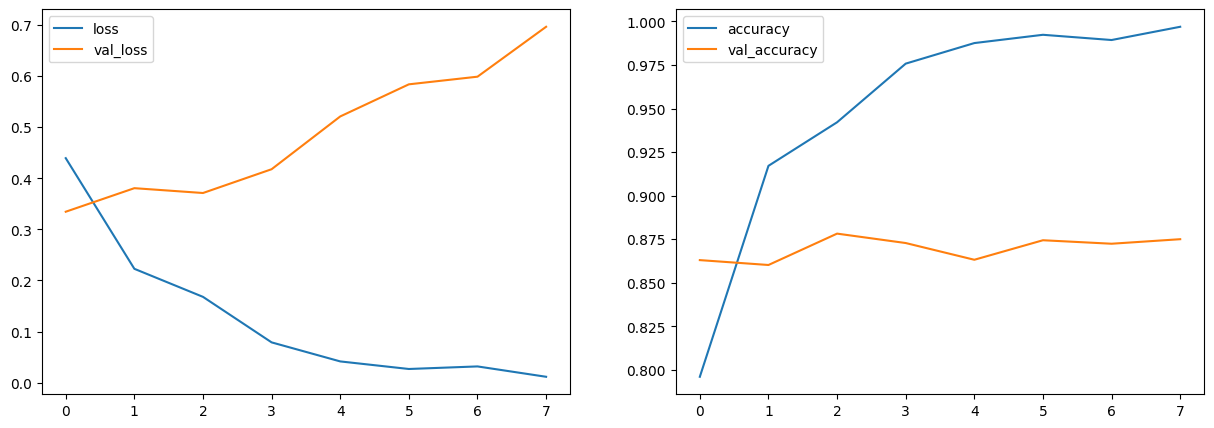

In [18]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [19]:
model = get_gru()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 70s 103ms/step - loss: 0.5637 - accuracy: 0.6885 - val_loss: 0.3995 - val_accuracy: 0.8310
Epoch 2/20
625/625 [==============================] - 35s 55ms/step - loss: 0.3154 - accuracy: 0.8755 - val_loss: 0.3784 - val_accuracy: 0.8522
Epoch 3/20
625/625 [==============================] - 28s 45ms/step - loss: 0.1728 - accuracy: 0.9399 - val_loss: 0.4581 - val_accuracy: 0.8538
Epoch 4/20
625/625 [==============================] - 24s 39ms/step - loss: 0.0847 - accuracy: 0.9742 - val_loss: 0.5665 - val_accuracy: 0.8638
Epoch 5/20
625/625 [==============================] - 23s 37ms/step - loss: 0.0416 - accuracy: 0.9888 - val_loss: 0.6502 - val_accuracy: 0.8526
Epoch 6/20
625/625 [==============================] - 23s 37ms/step - loss: 0.0166 - accuracy: 0.9961 - val_loss: 0.7437 - val_accuracy: 0.8558
Epoch 7/20
625/625 [==============================] - 23s 37ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.8556 - val_accuracy

evaluate train set
625/625 [==============================] - 8s 12ms/step - loss: 0.0349 - accuracy: 0.9891
[0.03487572818994522, 0.9891499876976013]
evaluate val set
157/157 [==============================] - 2s 12ms/step - loss: 0.5665 - accuracy: 0.8638
[0.5664903521537781, 0.8637999892234802]
evaluate test set
782/782 [==============================] - 11s 13ms/step - loss: 0.5380 - accuracy: 0.8662
[0.5379968881607056, 0.8661999702453613]


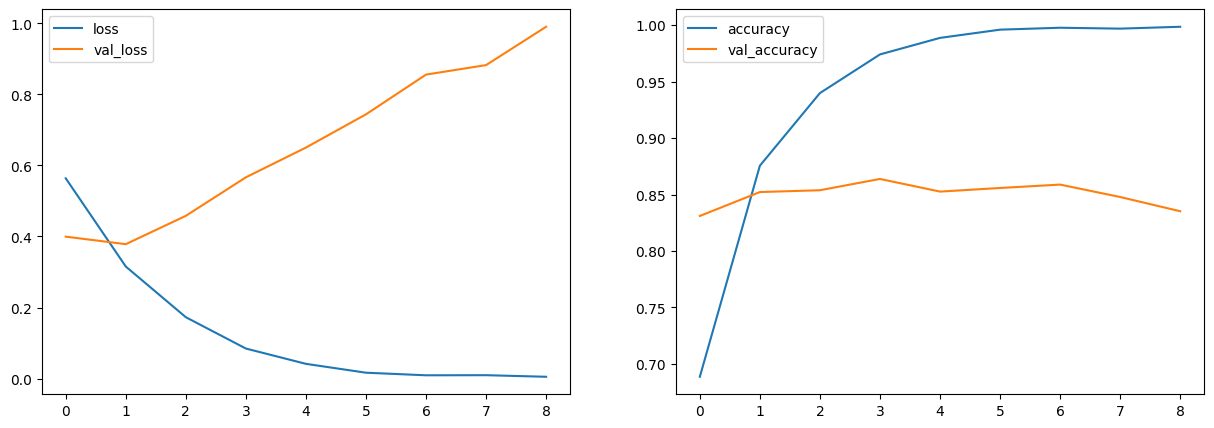

In [20]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (without mask_zero) + LSTM

In [21]:
def get_lstm():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128))
    model.add(LSTM(32, activation="tanh"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [22]:
get_lstm().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2580641 (9.84 MB)
Trainable params: 2580641 (9.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [23]:
model = get_lstm()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 62s 95ms/step - loss: 0.6940 - accuracy: 0.4988 - val_loss: 0.6930 - val_accuracy: 0.5034
Epoch 2/20
625/625 [==============================] - 36s 57ms/step - loss: 0.6913 - accuracy: 0.5082 - val_loss: 0.6938 - val_accuracy: 0.5044
Epoch 3/20
625/625 [==============================] - 26s 41ms/step - loss: 0.6816 - accuracy: 0.5136 - val_loss: 0.7047 - val_accuracy: 0.5028
Epoch 4/20
625/625 [==============================] - 22s 35ms/step - loss: 0.6668 - accuracy: 0.5242 - val_loss: 0.7191 - val_accuracy: 0.5022
Epoch 5/20
625/625 [==============================] - 20s 33ms/step - loss: 0.6609 - accuracy: 0.5337 - val_loss: 0.7344 - val_accuracy: 0.5022
Epoch 6/20
625/625 [==============================] - 20s 32ms/step - loss: 0.6604 - accuracy: 0.5226 - val_loss: 0.7249 - val_accuracy: 0.5030
Epoch 7/20
625/625 [==============================] - 19s 31ms/step - loss: 0.6589 - accuracy: 0.5217 - val_loss: 0.7480 - val_accuracy:

evaluate train set
625/625 [==============================] - 8s 13ms/step - loss: 0.3651 - accuracy: 0.8555
[0.36514368653297424, 0.8555499911308289]
evaluate val set
157/157 [==============================] - 2s 11ms/step - loss: 0.5099 - accuracy: 0.7816
[0.5098750591278076, 0.7815999984741211]
evaluate test set
782/782 [==============================] - 9s 11ms/step - loss: 0.5337 - accuracy: 0.7670
[0.5336751937866211, 0.7670000195503235]


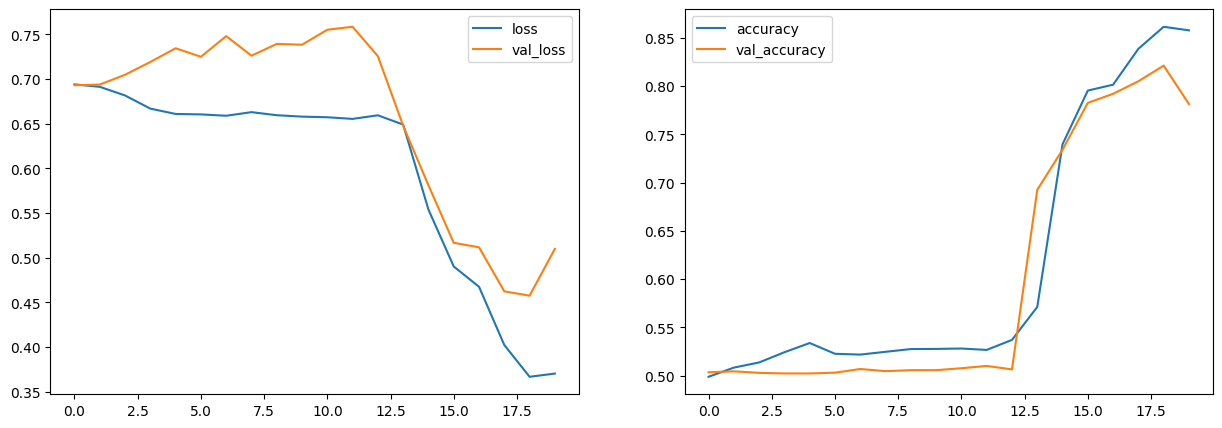

In [24]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [25]:
model = get_lstm()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 63s 96ms/step - loss: 0.6937 - accuracy: 0.5047 - val_loss: 0.6923 - val_accuracy: 0.5194
Epoch 2/20
625/625 [==============================] - 34s 55ms/step - loss: 0.6750 - accuracy: 0.5446 - val_loss: 0.6998 - val_accuracy: 0.5086
Epoch 3/20
625/625 [==============================] - 27s 43ms/step - loss: 0.5885 - accuracy: 0.5952 - val_loss: 0.7564 - val_accuracy: 0.5134
Epoch 4/20
625/625 [==============================] - 22s 35ms/step - loss: 0.5477 - accuracy: 0.6130 - val_loss: 0.8465 - val_accuracy: 0.5284
Epoch 5/20
625/625 [==============================] - 21s 33ms/step - loss: 0.5378 - accuracy: 0.6087 - val_loss: 0.9765 - val_accuracy: 0.5090
Epoch 6/20
625/625 [==============================] - 20s 32ms/step - loss: 0.5339 - accuracy: 0.6143 - val_loss: 0.9573 - val_accuracy: 0.5062
Epoch 7/20
625/625 [==============================] - 19s 31ms/step - loss: 0.5350 - accuracy: 0.6194 - val_loss: 1.0151 - val_accuracy:

evaluate train set
625/625 [==============================] - 8s 13ms/step - loss: 0.5415 - accuracy: 0.6187
[0.541512668132782, 0.6187000274658203]
evaluate val set
157/157 [==============================] - 2s 12ms/step - loss: 0.8465 - accuracy: 0.5284
[0.8464815616607666, 0.5284000039100647]
evaluate test set
782/782 [==============================] - 12s 15ms/step - loss: 0.8576 - accuracy: 0.5145
[0.8575915694236755, 0.514519989490509]


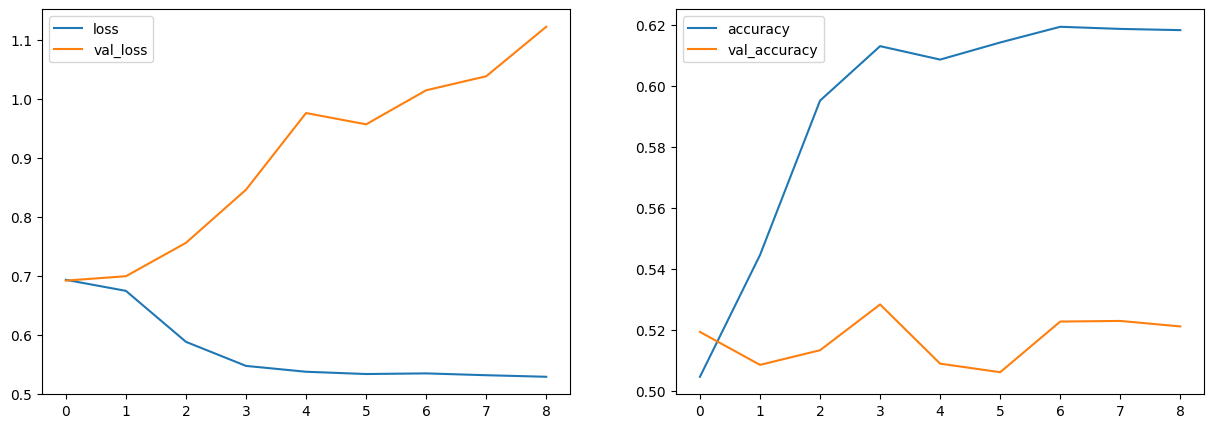

In [26]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (with mask_zero) + LSTM

In [27]:
def get_lstm():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True))
    model.add(LSTM(32, activation="tanh"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [28]:
get_lstm().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2580641 (9.84 MB)
Trainable params: 2580641 (9.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [29]:
model = get_lstm()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 78s 117ms/step - loss: 0.4490 - accuracy: 0.7933 - val_loss: 0.3347 - val_accuracy: 0.8604
Epoch 2/20
625/625 [==============================] - 41s 66ms/step - loss: 0.2427 - accuracy: 0.9097 - val_loss: 0.3956 - val_accuracy: 0.8302
Epoch 3/20
625/625 [==============================] - 29s 46ms/step - loss: 0.1494 - accuracy: 0.9487 - val_loss: 0.3654 - val_accuracy: 0.8664
Epoch 4/20
625/625 [==============================] - 27s 43ms/step - loss: 0.1061 - accuracy: 0.9655 - val_loss: 0.4091 - val_accuracy: 0.8578
Epoch 5/20
625/625 [==============================] - 23s 37ms/step - loss: 0.0866 - accuracy: 0.9714 - val_loss: 0.4632 - val_accuracy: 0.8586
Epoch 6/20
625/625 [==============================] - 24s 38ms/step - loss: 0.0581 - accuracy: 0.9815 - val_loss: 0.5047 - val_accuracy: 0.8604
Epoch 7/20
625/625 [==============================] - 22s 36ms/step - loss: 0.0501 - accuracy: 0.9851 - val_loss: 0.6115 - val_accuracy

evaluate train set
625/625 [==============================] - 7s 11ms/step - loss: 0.0846 - accuracy: 0.9719
[0.08456157147884369, 0.9718999862670898]
evaluate val set
157/157 [==============================] - 2s 15ms/step - loss: 0.3654 - accuracy: 0.8664
[0.3653828203678131, 0.8664000034332275]
evaluate test set
782/782 [==============================] - 10s 12ms/step - loss: 0.3720 - accuracy: 0.8626
[0.37204843759536743, 0.862559974193573]


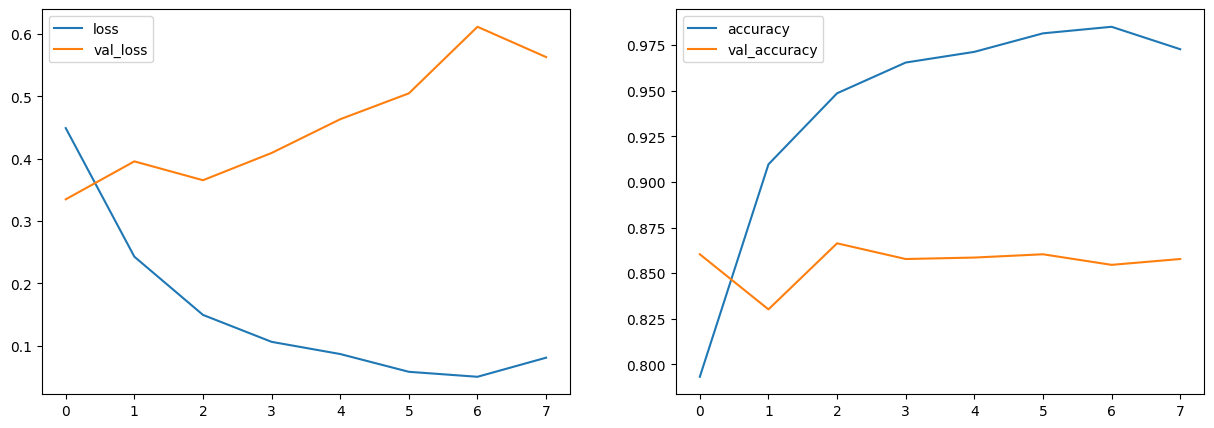

In [30]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [31]:
model = get_lstm()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 71s 107ms/step - loss: 0.5799 - accuracy: 0.6874 - val_loss: 0.4460 - val_accuracy: 0.8072
Epoch 2/20
625/625 [==============================] - 40s 64ms/step - loss: 0.3488 - accuracy: 0.8606 - val_loss: 0.3971 - val_accuracy: 0.8310
Epoch 3/20
625/625 [==============================] - 32s 50ms/step - loss: 0.2280 - accuracy: 0.9188 - val_loss: 0.4745 - val_accuracy: 0.8380
Epoch 4/20
625/625 [==============================] - 31s 50ms/step - loss: 0.1797 - accuracy: 0.9386 - val_loss: 0.5590 - val_accuracy: 0.8296
Epoch 5/20
625/625 [==============================] - 28s 44ms/step - loss: 0.0980 - accuracy: 0.9688 - val_loss: 0.7895 - val_accuracy: 0.7864
Epoch 6/20
625/625 [==============================] - 24s 38ms/step - loss: 0.1049 - accuracy: 0.9656 - val_loss: 0.6666 - val_accuracy: 0.8192
Epoch 7/20
625/625 [==============================] - 23s 36ms/step - loss: 0.0599 - accuracy: 0.9822 - val_loss: 0.8214 - val_accuracy

evaluate train set
625/625 [==============================] - 9s 14ms/step - loss: 0.1343 - accuracy: 0.9520
[0.13426944613456726, 0.9519500136375427]
evaluate val set
157/157 [==============================] - 2s 12ms/step - loss: 0.4745 - accuracy: 0.8380
[0.4744865596294403, 0.8379999995231628]
evaluate test set
782/782 [==============================] - 11s 14ms/step - loss: 0.4684 - accuracy: 0.8374
[0.4683617949485779, 0.837440013885498]


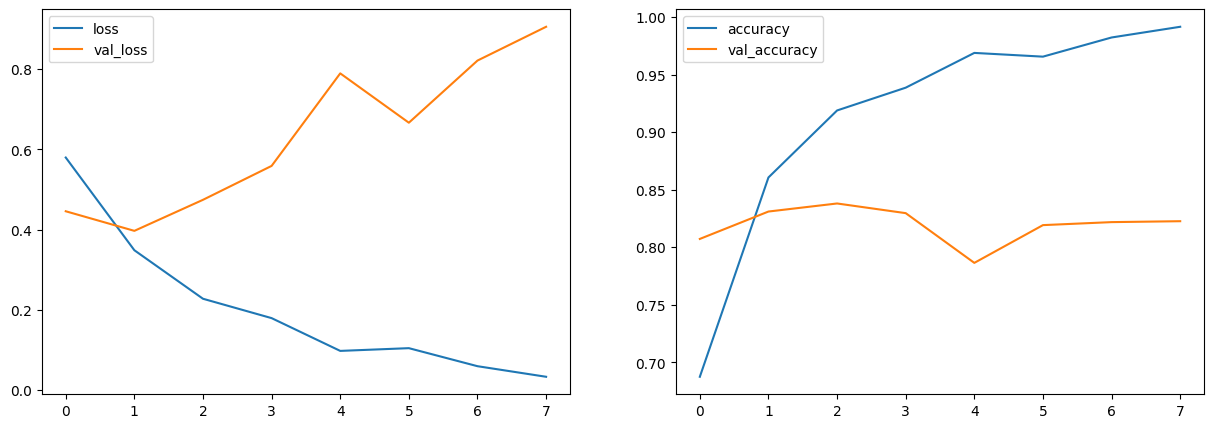

In [32]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (without mask_zero) + Bi-RNN

In [ ]:
def get_birnn():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128))
    model.add(Bidirectional(SimpleRNN(32, activation="tanh")))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
get_birnn().summary()

#### Unigrams with integer

In [ ]:
model = get_birnn()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

In [ ]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [ ]:
model = get_birnn()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

In [ ]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (with mask_zero) + Bi-RNN

In [ ]:
def get_birnn():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True))
    model.add(Bidirectional(SimpleRNN(32, activation="tanh")))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
get_birnn().summary()

#### Unigrams with integer

In [ ]:
model = get_birnn()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

In [ ]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [ ]:
model = get_birnn()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

In [ ]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (without mask_zero) + Bi-GRU

In [33]:
def get_bigru():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128))
    model.add(Bidirectional(GRU(32, activation="tanh")))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [34]:
get_bigru().summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirection  (None, 64)                31104     
 al)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2591169 (9.88 MB)
Trainable params: 2591169 (9.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [35]:
model = get_bigru()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 78s 118ms/step - loss: 0.6019 - accuracy: 0.6671 - val_loss: 0.4876 - val_accuracy: 0.7660
Epoch 2/20
625/625 [==============================] - 45s 72ms/step - loss: 0.3130 - accuracy: 0.8741 - val_loss: 0.3612 - val_accuracy: 0.8556
Epoch 3/20
625/625 [==============================] - 38s 61ms/step - loss: 0.1647 - accuracy: 0.9416 - val_loss: 0.3923 - val_accuracy: 0.8540
Epoch 4/20
625/625 [==============================] - 33s 53ms/step - loss: 0.0929 - accuracy: 0.9710 - val_loss: 0.5205 - val_accuracy: 0.8464
Epoch 5/20
625/625 [==============================] - 32s 51ms/step - loss: 0.0576 - accuracy: 0.9832 - val_loss: 0.5542 - val_accuracy: 0.8582
Epoch 6/20
625/625 [==============================] - 34s 54ms/step - loss: 0.0358 - accuracy: 0.9900 - val_loss: 0.6191 - val_accuracy: 0.8540
Epoch 7/20
625/625 [==============================] - 32s 50ms/step - loss: 0.0210 - accuracy: 0.9942 - val_loss: 0.6606 - val_accuracy

evaluate train set
625/625 [==============================] - 13s 20ms/step - loss: 0.0257 - accuracy: 0.9930
[0.025671575218439102, 0.9929999709129333]
evaluate val set
157/157 [==============================] - 3s 17ms/step - loss: 0.5542 - accuracy: 0.8582
[0.5541632771492004, 0.8582000136375427]
evaluate test set
782/782 [==============================] - 15s 19ms/step - loss: 0.6300 - accuracy: 0.8357
[0.6300017237663269, 0.8356800079345703]


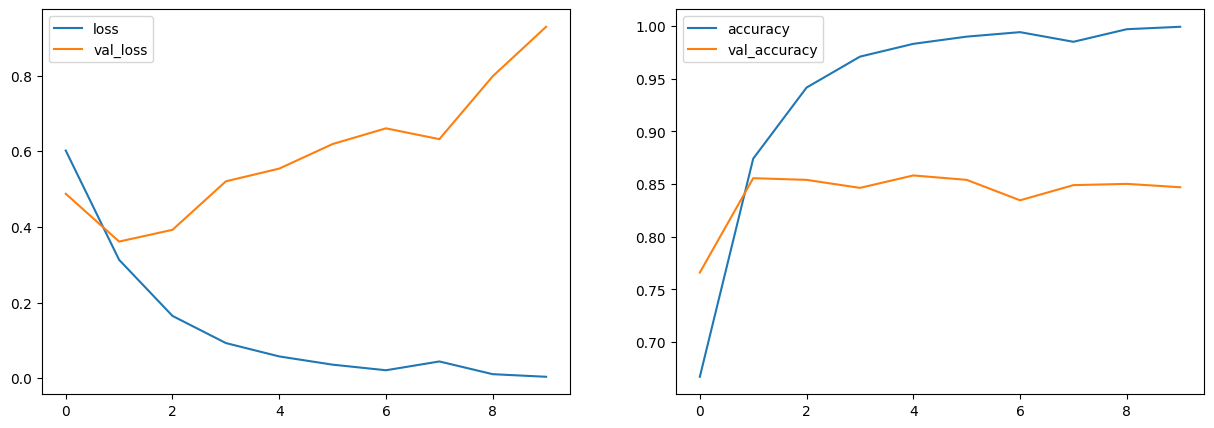

In [36]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [37]:
model = get_bigru()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 75s 113ms/step - loss: 0.5463 - accuracy: 0.7193 - val_loss: 0.4000 - val_accuracy: 0.8382
Epoch 2/20
625/625 [==============================] - 45s 72ms/step - loss: 0.3206 - accuracy: 0.8767 - val_loss: 0.3599 - val_accuracy: 0.8554
Epoch 3/20
625/625 [==============================] - 40s 63ms/step - loss: 0.2084 - accuracy: 0.9276 - val_loss: 0.3593 - val_accuracy: 0.8672
Epoch 4/20
625/625 [==============================] - 36s 57ms/step - loss: 0.1261 - accuracy: 0.9598 - val_loss: 0.4980 - val_accuracy: 0.8598
Epoch 5/20
625/625 [==============================] - 33s 53ms/step - loss: 0.0741 - accuracy: 0.9797 - val_loss: 0.4685 - val_accuracy: 0.8688
Epoch 6/20
625/625 [==============================] - 33s 53ms/step - loss: 0.0413 - accuracy: 0.9889 - val_loss: 0.5117 - val_accuracy: 0.8666
Epoch 7/20
625/625 [==============================] - 31s 49ms/step - loss: 0.0261 - accuracy: 0.9938 - val_loss: 0.5781 - val_accuracy

evaluate train set
625/625 [==============================] - 13s 21ms/step - loss: 0.0311 - accuracy: 0.9926
[0.03111778013408184, 0.9925500154495239]
evaluate val set
157/157 [==============================] - 3s 19ms/step - loss: 0.4685 - accuracy: 0.8688
[0.46847549080848694, 0.8687999844551086]
evaluate test set
782/782 [==============================] - 17s 22ms/step - loss: 0.4885 - accuracy: 0.8604
[0.4885489344596863, 0.8604400157928467]


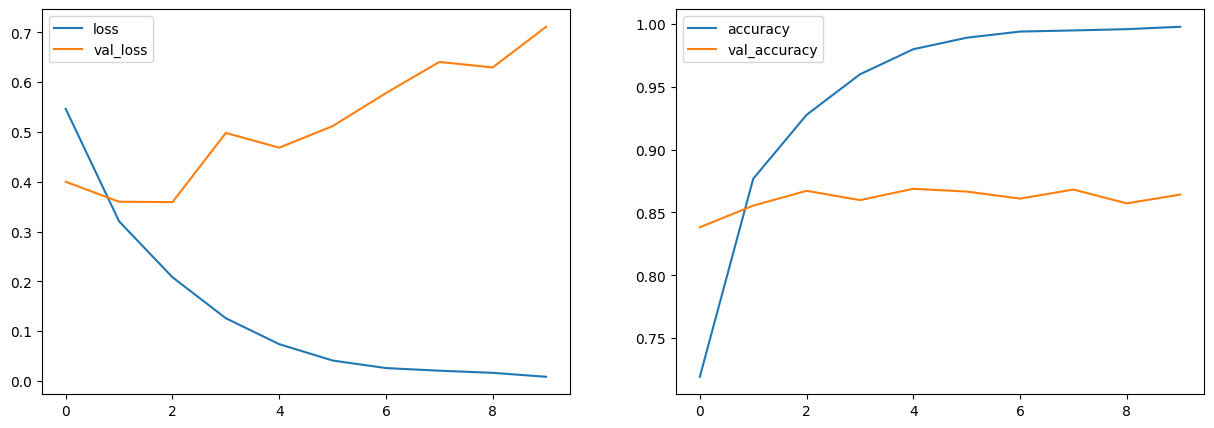

In [38]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (with mask_zero) + Bi-GRU

In [39]:
def get_bigru():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True))
    model.add(Bidirectional(GRU(32, activation="tanh")))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [40]:
get_bigru().summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 128)         2560000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2591169 (9.88 MB)
Trainable params: 2591169 (9.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [41]:
model = get_bigru()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 94s 134ms/step - loss: 0.4523 - accuracy: 0.7889 - val_loss: 0.3850 - val_accuracy: 0.8276
Epoch 2/20
625/625 [==============================] - 54s 87ms/step - loss: 0.2052 - accuracy: 0.9227 - val_loss: 0.3097 - val_accuracy: 0.8692
Epoch 3/20
625/625 [==============================] - 46s 74ms/step - loss: 0.1040 - accuracy: 0.9634 - val_loss: 0.4088 - val_accuracy: 0.8694
Epoch 4/20
625/625 [==============================] - 39s 62ms/step - loss: 0.0519 - accuracy: 0.9825 - val_loss: 0.5045 - val_accuracy: 0.8662
Epoch 5/20
625/625 [==============================] - 39s 62ms/step - loss: 0.0356 - accuracy: 0.9887 - val_loss: 0.5622 - val_accuracy: 0.8572
Epoch 6/20
625/625 [==============================] - 38s 61ms/step - loss: 0.0298 - accuracy: 0.9898 - val_loss: 0.5375 - val_accuracy: 0.8720
Epoch 7/20
625/625 [==============================] - 41s 65ms/step - loss: 0.0130 - accuracy: 0.9963 - val_loss: 0.6174 - val_accuracy

evaluate train set
625/625 [==============================] - 14s 22ms/step - loss: 0.0019 - accuracy: 0.9993
[0.001856597955338657, 0.9993000030517578]
evaluate val set
157/157 [==============================] - 3s 20ms/step - loss: 0.8343 - accuracy: 0.8752
[0.8343228697776794, 0.8751999735832214]
evaluate test set
782/782 [==============================] - 17s 22ms/step - loss: 0.9862 - accuracy: 0.8595
[0.9862356185913086, 0.8595200181007385]


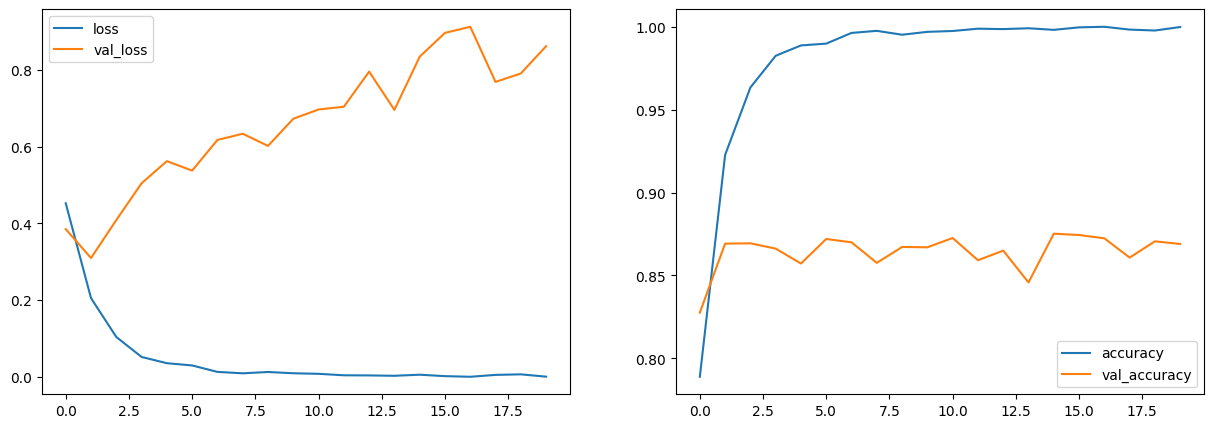

In [42]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [43]:
model = get_bigru()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 93s 134ms/step - loss: 0.5073 - accuracy: 0.7372 - val_loss: 0.3898 - val_accuracy: 0.8268
Epoch 2/20
625/625 [==============================] - 55s 88ms/step - loss: 0.2276 - accuracy: 0.9101 - val_loss: 0.3689 - val_accuracy: 0.8380
Epoch 3/20
625/625 [==============================] - 47s 74ms/step - loss: 0.1146 - accuracy: 0.9574 - val_loss: 0.4135 - val_accuracy: 0.8544
Epoch 4/20
625/625 [==============================] - 44s 70ms/step - loss: 0.0603 - accuracy: 0.9789 - val_loss: 0.4900 - val_accuracy: 0.8386
Epoch 5/20
625/625 [==============================] - 42s 67ms/step - loss: 0.0468 - accuracy: 0.9816 - val_loss: 0.6219 - val_accuracy: 0.8206
Epoch 6/20
625/625 [==============================] - 38s 60ms/step - loss: 0.0196 - accuracy: 0.9935 - val_loss: 0.6787 - val_accuracy: 0.8482
Epoch 7/20
625/625 [==============================] - 37s 59ms/step - loss: 0.0161 - accuracy: 0.9951 - val_loss: 0.7410 - val_accuracy

evaluate train set
625/625 [==============================] - 14s 22ms/step - loss: 0.0556 - accuracy: 0.9842
[0.05558590218424797, 0.9842000007629395]
evaluate val set
157/157 [==============================] - 4s 24ms/step - loss: 0.4135 - accuracy: 0.8544
[0.4134732484817505, 0.8543999791145325]
evaluate test set
782/782 [==============================] - 17s 21ms/step - loss: 0.4100 - accuracy: 0.8544
[0.40995359420776367, 0.8543999791145325]


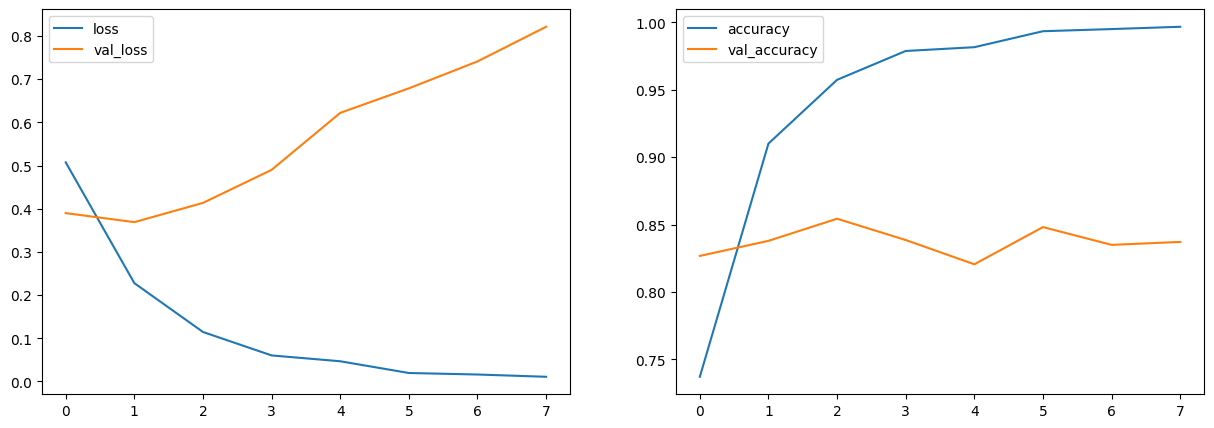

In [44]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (without mask_zero) + Bi-LSTM

In [12]:
def get_bilstm():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128))
    model.add(Bidirectional(LSTM(32, activation="tanh")))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [13]:
get_bilstm().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirection  (None, 64)                41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2601281 (9.92 MB)
Trainable params: 2601281 (9.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [47]:
model = get_bilstm()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 76s 115ms/step - loss: 0.5114 - accuracy: 0.7548 - val_loss: 0.3984 - val_accuracy: 0.8370
Epoch 2/20
625/625 [==============================] - 48s 77ms/step - loss: 0.4174 - accuracy: 0.8334 - val_loss: 0.6801 - val_accuracy: 0.5652
Epoch 3/20
625/625 [==============================] - 38s 61ms/step - loss: 0.5368 - accuracy: 0.7303 - val_loss: 0.4748 - val_accuracy: 0.8004
Epoch 4/20
625/625 [==============================] - 36s 58ms/step - loss: 0.3247 - accuracy: 0.8806 - val_loss: 0.4701 - val_accuracy: 0.8082
Epoch 5/20
625/625 [==============================] - 34s 55ms/step - loss: 0.2542 - accuracy: 0.9126 - val_loss: 0.5121 - val_accuracy: 0.7954
Epoch 6/20
625/625 [==============================] - 32s 51ms/step - loss: 0.2516 - accuracy: 0.9100 - val_loss: 0.4560 - val_accuracy: 0.8336


evaluate train set
625/625 [==============================] - 14s 23ms/step - loss: 0.3013 - accuracy: 0.8924
[0.3013249933719635, 0.8923500180244446]
evaluate val set
157/157 [==============================] - 3s 18ms/step - loss: 0.3984 - accuracy: 0.8370
[0.39837145805358887, 0.8370000123977661]
evaluate test set
782/782 [==============================] - 17s 21ms/step - loss: 0.4182 - accuracy: 0.8246
[0.4181957542896271, 0.8246399760246277]


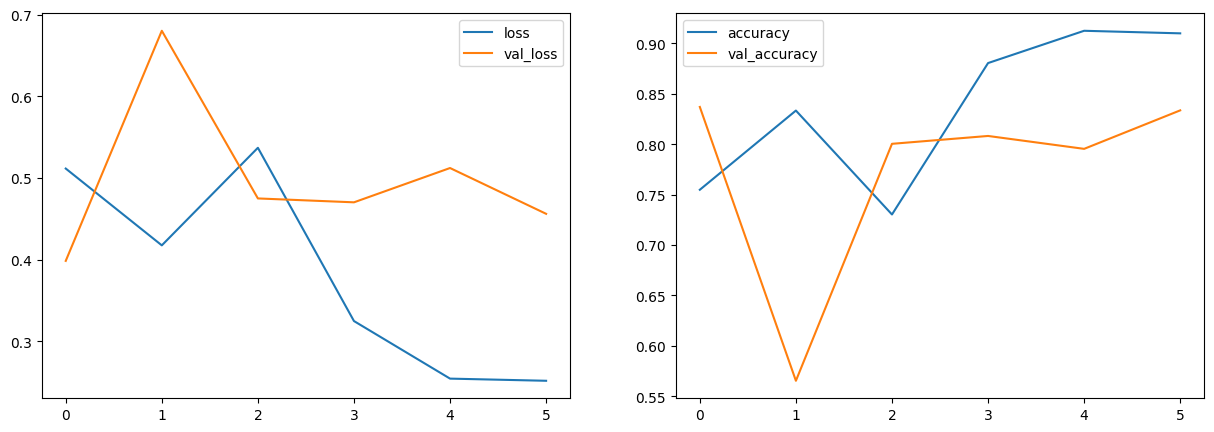

In [48]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [14]:
model = get_bilstm()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 81s 120ms/step - loss: 0.4890 - accuracy: 0.7660 - val_loss: 0.4047 - val_accuracy: 0.8258
Epoch 2/20
625/625 [==============================] - 51s 82ms/step - loss: 0.3593 - accuracy: 0.8572 - val_loss: 0.3859 - val_accuracy: 0.8514
Epoch 3/20
625/625 [==============================] - 38s 61ms/step - loss: 0.2436 - accuracy: 0.9143 - val_loss: 0.4489 - val_accuracy: 0.8204
Epoch 4/20
625/625 [==============================] - 35s 56ms/step - loss: 0.1681 - accuracy: 0.9464 - val_loss: 0.4335 - val_accuracy: 0.8550
Epoch 5/20
625/625 [==============================] - 35s 57ms/step - loss: 0.3058 - accuracy: 0.8751 - val_loss: 0.5114 - val_accuracy: 0.8054
Epoch 6/20
625/625 [==============================] - 31s 50ms/step - loss: 0.1598 - accuracy: 0.9463 - val_loss: 0.5262 - val_accuracy: 0.8332
Epoch 7/20
625/625 [==============================] - 31s 50ms/step - loss: 0.0931 - accuracy: 0.9712 - val_loss: 0.5929 - val_accuracy

evaluate train set
625/625 [==============================] - 13s 21ms/step - loss: 0.0939 - accuracy: 0.9722
[0.09391894936561584, 0.9722499847412109]
evaluate val set
157/157 [==============================] - 3s 19ms/step - loss: 0.4335 - accuracy: 0.8550
[0.43347039818763733, 0.8550000190734863]
evaluate test set
782/782 [==============================] - 18s 22ms/step - loss: 0.4403 - accuracy: 0.8498
[0.44026824831962585, 0.8497999906539917]


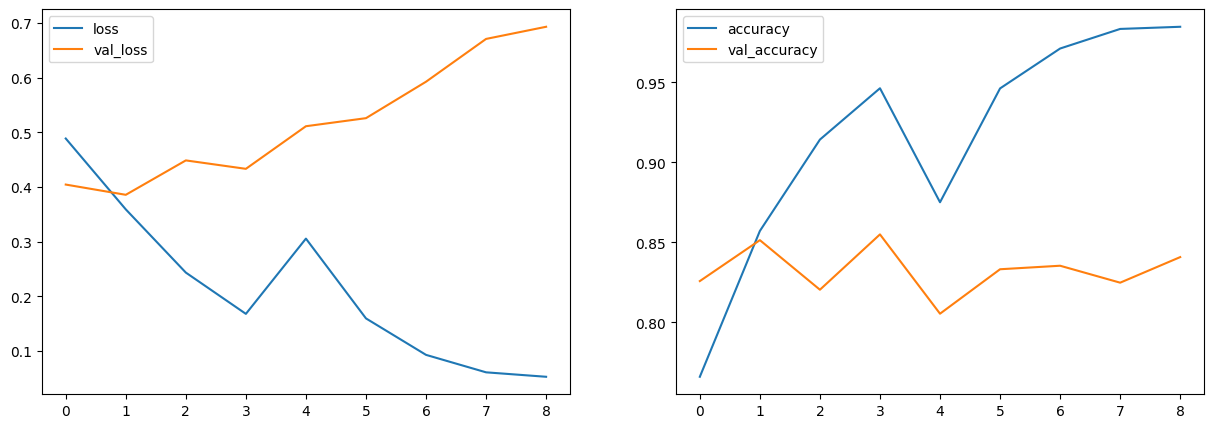

In [15]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

### Embedding (with mask_zero) + Bi-LSTM

In [51]:
def get_bilstm():
    model = Sequential()
    model.add(Input(shape=(None,)))
    model.add(Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True))
    model.add(Bidirectional(LSTM(32, activation="tanh")))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [52]:
get_bilstm().summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirection  (None, 64)                41216     
 al)                                                             
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2601281 (9.92 MB)
Trainable params: 2601281 (9.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Unigrams with integer

In [53]:
model = get_bilstm()
history = model_fit(model, int_1gram_train_ds, int_1gram_val_ds)

Epoch 1/20
625/625 [==============================] - 192s 126ms/step - loss: 0.4027 - accuracy: 0.8112 - val_loss: 0.3140 - val_accuracy: 0.8704
Epoch 2/20
625/625 [==============================] - 49s 79ms/step - loss: 0.2013 - accuracy: 0.9237 - val_loss: 0.3600 - val_accuracy: 0.8448
Epoch 3/20
625/625 [==============================] - 39s 63ms/step - loss: 0.1103 - accuracy: 0.9624 - val_loss: 0.3610 - val_accuracy: 0.8624
Epoch 4/20
625/625 [==============================] - 38s 60ms/step - loss: 0.0668 - accuracy: 0.9781 - val_loss: 0.4321 - val_accuracy: 0.8652
Epoch 5/20
625/625 [==============================] - 35s 56ms/step - loss: 0.0425 - accuracy: 0.9872 - val_loss: 0.5469 - val_accuracy: 0.8484
Epoch 6/20
625/625 [==============================] - 33s 53ms/step - loss: 0.0400 - accuracy: 0.9866 - val_loss: 0.5910 - val_accuracy: 0.8718
Epoch 7/20
625/625 [==============================] - 35s 57ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.6316 - val_accurac

evaluate train set
625/625 [==============================] - 12s 20ms/step - loss: 0.0116 - accuracy: 0.9964
[0.011613955721259117, 0.996399998664856]
evaluate val set
157/157 [==============================] - 3s 20ms/step - loss: 0.5910 - accuracy: 0.8718
[0.59096759557724, 0.8718000054359436]
evaluate test set
782/782 [==============================] - 15s 20ms/step - loss: 0.6451 - accuracy: 0.8576
[0.6451461911201477, 0.8576400279998779]


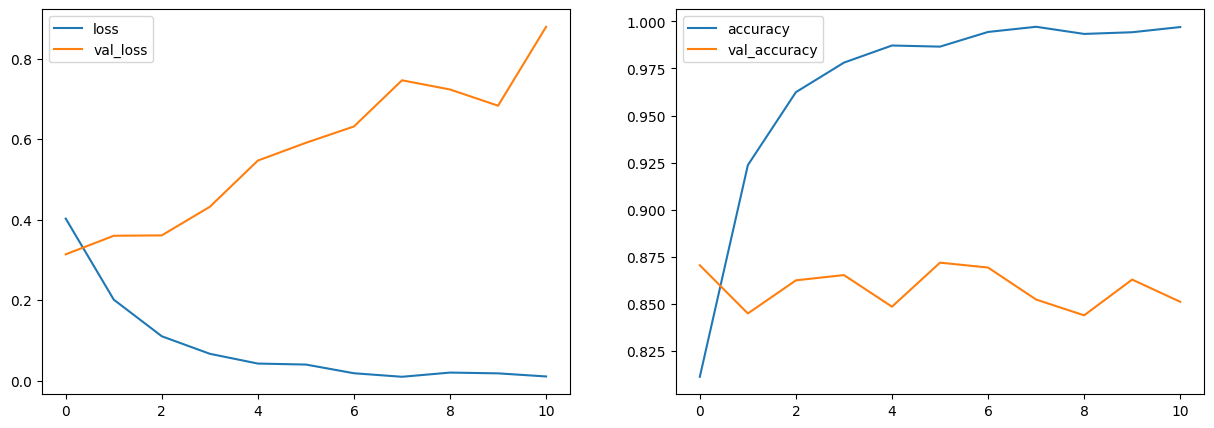

In [54]:
plot_loss(int_1gram_train_ds, int_1gram_val_ds, int_1gram_test_ds)

#### Bigrams with integer indices

In [55]:
model = get_bilstm()
history = model_fit(model, int_2gram_train_ds, int_2gram_val_ds)

Epoch 1/20
625/625 [==============================] - 89s 129ms/step - loss: 0.4898 - accuracy: 0.7631 - val_loss: 0.3543 - val_accuracy: 0.8494
Epoch 2/20
625/625 [==============================] - 53s 85ms/step - loss: 0.2979 - accuracy: 0.8778 - val_loss: 0.3790 - val_accuracy: 0.8300
Epoch 3/20
625/625 [==============================] - 45s 72ms/step - loss: 0.1729 - accuracy: 0.9348 - val_loss: 0.4694 - val_accuracy: 0.8358
Epoch 4/20
625/625 [==============================] - 39s 62ms/step - loss: 0.0858 - accuracy: 0.9697 - val_loss: 0.4736 - val_accuracy: 0.8498
Epoch 5/20
625/625 [==============================] - 38s 61ms/step - loss: 0.0423 - accuracy: 0.9865 - val_loss: 0.5369 - val_accuracy: 0.8428
Epoch 6/20
625/625 [==============================] - 40s 63ms/step - loss: 0.0382 - accuracy: 0.9875 - val_loss: 0.6258 - val_accuracy: 0.8426
Epoch 7/20
625/625 [==============================] - 36s 58ms/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.6921 - val_accuracy

evaluate train set
625/625 [==============================] - 15s 23ms/step - loss: 0.0325 - accuracy: 0.9903
[0.03252476826310158, 0.9902999997138977]
evaluate val set
157/157 [==============================] - 3s 20ms/step - loss: 0.4736 - accuracy: 0.8498
[0.47356778383255005, 0.8497999906539917]
evaluate test set
782/782 [==============================] - 19s 24ms/step - loss: 0.4973 - accuracy: 0.8464
[0.49733543395996094, 0.8464000225067139]


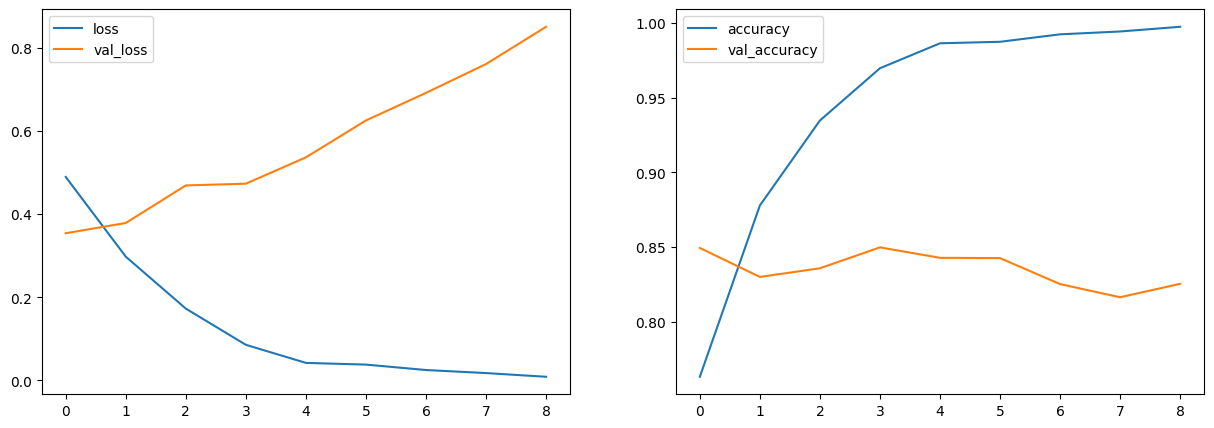

In [56]:
plot_loss(int_2gram_train_ds, int_2gram_val_ds, int_2gram_test_ds)

# Results and Discussions

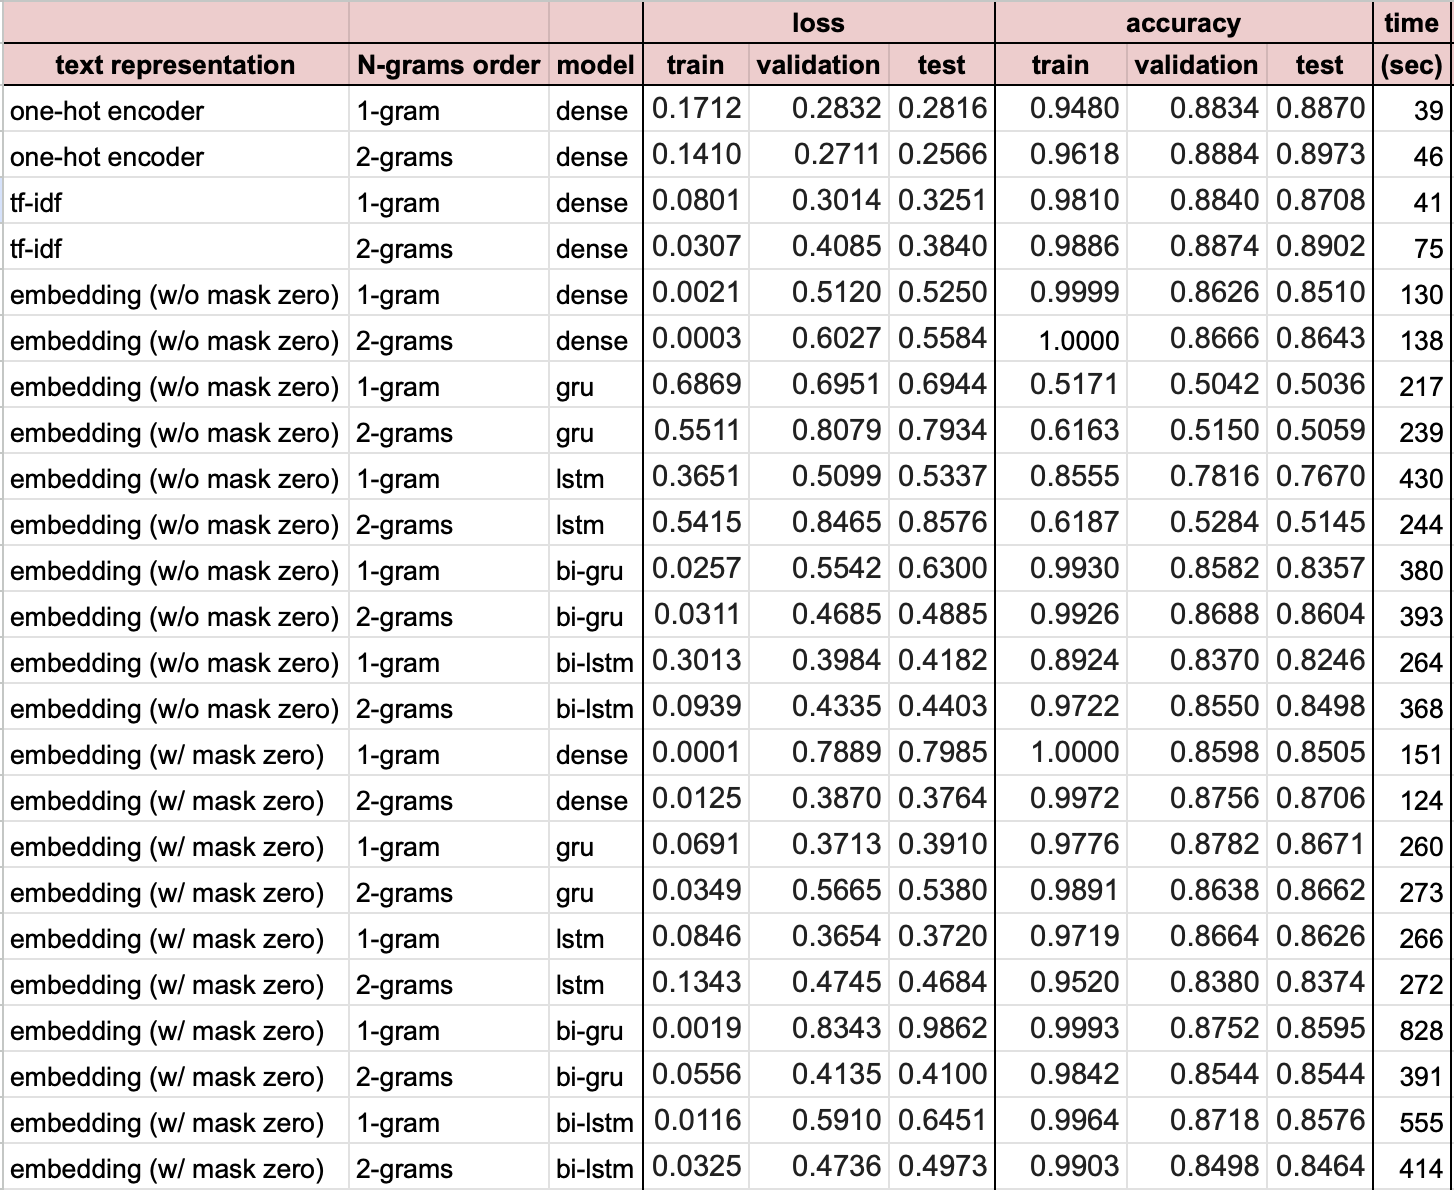

The key observations and conclusions from the evaluation results of sentiment classifiers can be summarise :

1. Effectiveness of Text Representations:
>- One-hot encoding, TF-IDF and embedding layer exhibit varying performance across n-gram orders and models.
>- One-hot encoding consistently outperform other text representations, showing higher accuracy and lower loss on test set.

2. Impact of N-gram Orders:
>- Higher order n-grams (2-grams) generally lead to improved accuracy compared to lower order n-grams (1-gram) across various text representations.

3. Model Performance:
>- Dense outperform Recurrent Neural Network (RNN), Gated Recurrent Unit (GRU), and Long Short-Term Memory (LSTM), particularly when using one-hot encoding and tf-idf with higher order n-grams (2-grams).

4. Training Time and number of training parameters
>- Dense models have less training time compared to Recurrent Neural Network (RNN), Gated Recurrent Unit (GRU), and Long Short-Term Memory (LSTM) models while having over two times the number of training parameters.

5. Mask zero in sequence modelling
>- It is a way to tell sequence-processing layers that certain timesteps in an input are missing and should not be influenting to training paremeter
>- The result shown that omitting the use of `mask_zero=True` adversely impacts the model's learning process. Considering that padding doesn't meaningful text, its inclusion in the model for learning is deemed inappropriate.

# Future Work

1. Exploration of Higher N-gram Orders:
>- Investigate the impact of even higher order n-grams (n=3, 4, 5, 6, 7, etc.) in combination with dense models. This exploration could reveal whether further context enrichment enhances sentiment classification accuracy or if diminishing returns are encountered.

2. Optimizing Dense Models with Varied Architectures:
>- Experiment with different dense model architectures and handling overfitting, exploring variations in layer configurations, activation functions, optimizer, initialization weight and regularization techniques. Fine-tuning the dense model architecture may uncover more efficient representations of complex relationships within sentiment data.
- Handling overfitting

3. Adaptive Learning Rate Strategies:
>- Implement adaptive learning rate strategies, such as learning rate schedules to put the overfitting off. This could potentially address the higher number of training parameters in dense models without compromising performance.

4. Investigation of Ensemble Techniques:
>- Explore ensemble techniques such as hard or soft Voting, that combine predictions from multiple models, including both dense and sequential models. Ensemble methods often lead to improved generalization and robustness, potentially mitigating the impact of a higher number of parameters.


# Reference

1. Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).
2. https://www.tensorflow.org/api_docs/